# OFDFT optimization wrt $\rho(r)$ -- N-conserving

In [1]:
import scipy.optimize
from scipy.optimize import minimize

In [57]:
help(scipy.optimize.minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        Objective function.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (Jacobian, Hessian).
    method : str or callable, op

In [3]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
    
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField

from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF
from pbcpy.semilocal_xc import PBE, LDA, XC
from pbcpy.local_pseudopotential import NuclearElectron
from pbcpy.hartree import HartreeFunctional
from pbcpy.functionals import *
from pbcpy.local_functionals_utils import TF,vW, x_TF_y_vW
from pbcpy.ewald import ewald

In [4]:
mol = PP(filepp='Al_fde_rho.pp').read()
ions = mol.ions
rho = mol.field
grid = mol.cell
N=rho.integral()

PP_file not set in input. Can do so manually invoking Atom.local_PP
PP_file not set in input. Can do so manually invoking Atom.local_PP


In [10]:
def EnergyDensityAndPotential(rho,ions):
    '''rho: real-space density
    ions: collection of Atoms'''
    EeN                 = NuclearElectron(ions,rho,["./Al_lda.oe01.recpot","./Al_lda.oe01.recpot"])
    Hartree             = HartreeFunctional(rho)
    ExchangeCorrelation = LDA(rho,polarization='unpolarized')
    KEDF                = x_TF_y_vW(rho,x=1.0,y=1.0/9.0,Sigma=0.0)
    EnergyDensity     = KEDF.energydensity-EeN.energydensity+Hartree.energydensity+ExchangeCorrelation.energydensity
    Potential         = KEDF.potential + ExchangeCorrelation.potential + Hartree.potential - EeN.potential
    return EnergyDensity, Potential

In [40]:
def E_v_phi(phi):
    phi_ = DirectField(grid,griddata_3d=np.reshape(phi,np.shape(rho)),rank=1)
    #phi_=phi
    rho_ = phi_*phi_
    N_=rho_.integral()
    rho_ *= N/N_
    Edens, v_ = EnergyDensityAndPotential(rho_,ions)
    E=Edens.integral()
    #print("E = ",E)
    int_tem_ = phi_*phi_*v_
    other_term_ = - int_tem_.integral() / N_
    #other_term_ = 0.0
    the_v_ =  v_  
    final_v_ = ( the_v_ + other_term_ ) * 2.0 * phi_  * N/N_ * grid.dV
    return E , final_v_ #.ravel()

In [7]:
#x0=np.sqrt(rho).ravel()
x1=np.zeros_like(rho)
x1[:,:,:,:]=np.sqrt(N / grid.Volume)
print(np.shape(x1))

(36, 36, 72, 1)


In [54]:
res = minimize(fun=E_v_phi_ravel,jac=True,x0=x0,method='L-BFGS-B',options={'disp': None, 'maxcor': 20, 'ftol': 1.0e-6, 'gtol': 1e-6, 'maxfun': 1000, 'maxiter': 100, 'maxls': 10})

In [51]:
res = minimize(fun=E_v_phi_ravel,jac=True,x0=x0,method='Newton-CG',options={'disp': None, 'maxiter': 100})

/Users/michele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: maxcor, ftol, gtol, maxfun, maxls
  """Entry point for launching an IPython kernel.


In [55]:
res.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

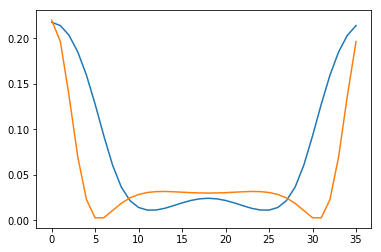

In [56]:
rho_ = DirectField(grid,griddata_3d=np.reshape(res.x**2,np.shape(rho)),rank=1)
plt.plot(rho_[:,0,0,0])
plt.plot(rho[:,0,0,0])
plt.show()

In [18]:
# check gradient
def pot_i_r(eps,n):
    #phi = np.sqrt(rho.copy()).ravel()
    phi = x1
    E, v = E_v_phi(phi)
    gradr = np.zeros(np.shape(phi))
    for i in range(n):
        phi[i,0,0,0]=phi[i,0,0,0]+eps
        Er, vr = E_v_phi(phi)
        r_grad=(Er-E)/eps
        phi[i,0,0,0]=phi[i,0,0,0]-eps
        gradr[i,0,0,0] = r_grad
    return gradr[0:n,0,0,0]/np.real(v[0:n,0,0,0])

In [37]:
pot_i_r(0.000001,20)

DirectField([ 1.0334578 ,  1.02987336,  1.03282425,  1.03641881,
              1.04111594,  1.06848569,  1.00092322,  0.99781694,
              1.00295238,  1.00620606,  0.99885624,  1.00127919,
              0.99937556,  1.00164253,  0.99915119,  1.00391911,
              0.99904461,  1.01656968,  1.00647363,  1.01187076])

In [44]:
#x0=np.sqrt(rho).ravel()
x0=np.zeros_like(rho)
x0[:,:,:,:]=np.sqrt(N / grid.Volume)
x0 = x0.ravel()
print(np.shape(x0))

(93312,)


In [41]:
def E_v_phi_ravel(phi):
    phi_ = DirectField(grid,griddata_3d=np.reshape(phi,np.shape(rho)),rank=1) # I suspect this takes time...
    #phi_=phi
    rho_ = phi_*phi_
    N_=rho_.integral()
    rho_ *= N/N_
    Edens, v_ = EnergyDensityAndPotential(rho_,ions) # of course, this takes time as well
    E=Edens.integral()
    #print("E = ",E)
    int_tem_ = phi_*phi_*v_
    other_term_ = - int_tem_.integral() / N_
    #other_term_ = 0.0
    the_v_ =  v_  
    final_v_ = ( the_v_ + other_term_ ) * 2.0 * phi_  * N/N_ * grid.dV
    return E , final_v_.ravel()

In [42]:
# check gradient
def pot_i_r_ravel(eps,n):
    #phi = np.sqrt(rho.copy()).ravel()
    phi = x0
    E, v = E_v_phi_ravel(phi)
    dim = np.shape(phi)
    gradr = np.zeros(np.shape(phi))
    for i in range(n):
        phi[i]=phi[i]+eps
        Er, vr = E_v_phi(phi)
        phi[i]=phi[i]-eps
        r_grad=(Er-E)/eps
        gradr[i] = r_grad
    return gradr[0:n]/np.real(v[0:n])

In [45]:
pot_i_r_ravel(0.001,5)

DirectField([ 0.93454935,  0.93357   ,  0.93060387,  0.92531808,
              0.91658783])